In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
from sklearn.utils import resample

ModuleNotFoundError: ignored

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# text preprocessing modules
from string import punctuation 
# text preprocessing modules
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression
# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [ ]:
print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.12.0
Running on TPU  grpc://10.71.125.130:8470


REPLICAS:  8


In [ ]:
#pip install transformers

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/answer.csv')
data = data.dropna()

In [ ]:
data.isnull().sum()

Unnamed: 0     0
QuestionUno    0
Category       0
PostText       0
label          0
clean_text     0
dtype: int64

In [ ]:
num_classes=len(data.label.unique())

In [ ]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [ ]:
max_len=500
sentences=data['clean_text']
labels=data['label']
len(sentences),len(labels)

(164501, 164501)

In [ ]:
pickle_inp_path='/content/drive/MyDrive/dbertA_inp.pkl'
pickle_mask_path='/content/drive/MyDrive/dbertA_mask.pkl'
pickle_label_path='/content/drive/MyDrive/dbertA_label.pkl'

In [ ]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [ ]:
pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Pickle files saved as  /content/drive/MyDrive/dbertA_inp.pkl /content/drive/MyDrive/dbertA_mask.pkl /content/drive/MyDrive/dbertA_label.pkl


In [ ]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))


Loading the saved pickle files..
Input shape (164501, 500) Attention mask shape (164501, 500) Input label shape (164501,)


In [ ]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))


log_dir='dbert_model'
model_save_path='/content/drive/MyDrive/bertmodel.h5'


Train inp shape (131600, 500) Val input shape (32901, 500)
Train label shape (131600,) Val label shape (32901,)
Train attention mask shape (131600, 500) Val attention mask shape (32901, 500)


In [ ]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [ ]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
    return model   

In [ ]:
with strategy.scope(): 
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-5)
  dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
  model=create_model()
  


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 500, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
STEPS_PER_EPOCH = len(train_inp) // 16

In [ ]:
STEPS_PER_EPOCH

7402

In [ ]:
history=model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=4,steps_per_epoch=STEPS_PER_EPOCH,validation_data=([val_inp,val_mask],val_label))


Epoch 1/4


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8225/8225 [==============================] - 615s 69ms/step - loss: 1.1901 - accuracy: 0.9151 - val_loss: 0.2922 - val_accuracy: 0.9220
Epoch 2/4
8225/8225 [==============================] - 556s 68ms/step - loss: 0.2660 - accuracy: 0.9252 - val_loss: 0.2617 - val_accuracy: 0.9230
Epoch 3/4
8225/8225 [==============================] - 553s 67ms/step - loss: 0.2354 - accuracy: 0.9321 - val_loss: 0.2622 - val_accuracy: 0.9233
Epoch 4/4
8225/8225 [==============================] - 555s 67ms/step - loss: 0.2106 - accuracy: 0.9379 - val_loss: 0.2681 - val_accuracy: 0.9215


In [ ]:
preds = model.predict([val_inp,val_mask],batch_size=16)
pred_labels = preds.argmax(axis=1)


2057/2057 [==============================] - 49s 22ms/step


In [ ]:

print('Classification Report')
print(classification_report(val_label,pred_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     10357
           1       0.92      0.97      0.94     22544

    accuracy                           0.92     32901
   macro avg       0.92      0.89      0.91     32901
weighted avg       0.92      0.92      0.92     32901



<ipython-input-29-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


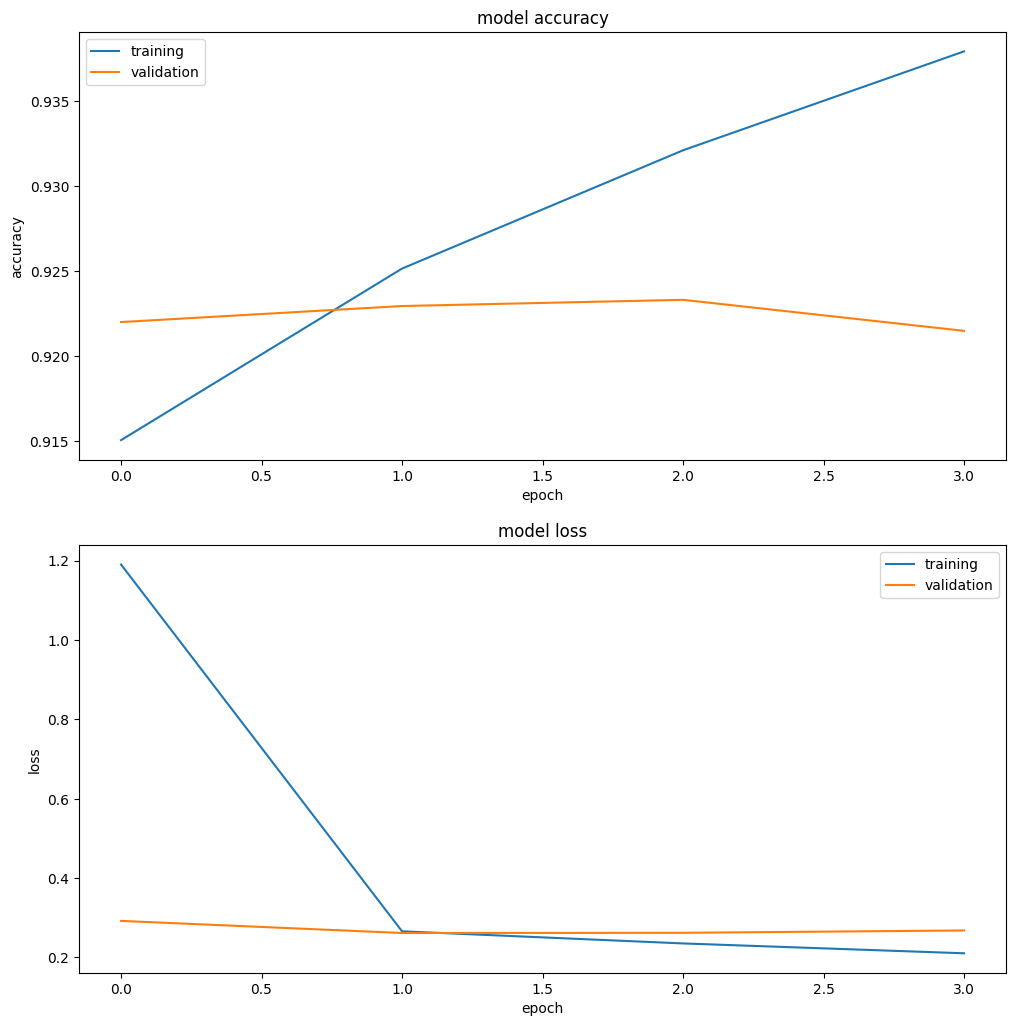

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
import seaborn as sns

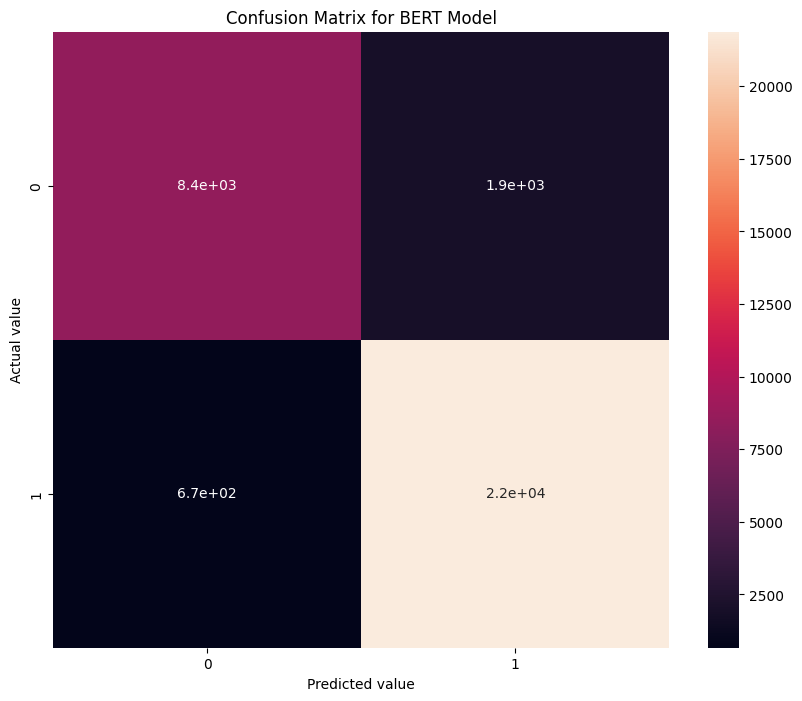

In [ ]:
plt.figure(figsize=(10, 8))
mat = confusion_matrix(val_label, pred_labels)
plt.title("Confusion Matrix for BERT Model")
sns.heatmap(mat, square=True, annot=True)
plt.xlabel('Predicted value')
plt.ylabel('Actual value');

In [ ]:
Pkl_Filename = "tfbert.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

/usr/local/lib/python3.9/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


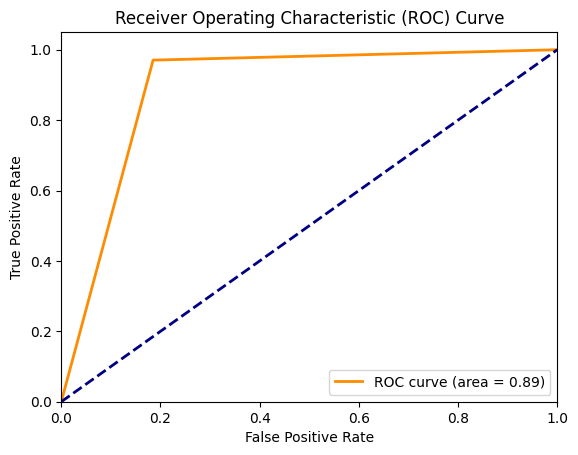

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
fpr, tpr, thresholds = roc_curve(val_label, pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()